In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import cm
sns.set_style('ticks')

In [17]:
pd.read_csv('test/pdb_data_no_dups.csv').to_pickle('test/pdb_data_no_dups.pickle')
pd.read_csv('test/pdb_data_seq.csv').to_pickle('test/pdb_data_seq.pickle')

In [19]:
df_dup_raw = pd.read_pickle('test/pdb_data_no_dups.pickle')
df_seq_raw = pd.read_pickle('test/pdb_data_seq.pickle')

In [196]:
merged_df = pd.merge(df_dup_raw,df_seq_raw, on = 'structureId',how='inner')
merged_df.rename({'macromoleculeType_x':'macromoleculeType',
                                            'residueCount_y':'residueCount'},axis=1,inplace=True)
merged_df.drop(['macromoleculeType_y','residueCount_x'],axis=1,inplace=True)


In [198]:
missing_df = pd.DataFrame(merged_df.isnull().sum().sort_values(ascending=False)/merged_df.shape[0] * 100).reset_index()
missing_df.columns = ['Name', 'Missingness(%)']
missing_df

,Name,Missingness(%)
0,crystallizationMethod,33.194382
1,crystallizationTempK,32.569739
2,phValue,27.688693
3,pdbxDetails,18.185542
4,densityMatthews,17.298986
5,densityPercentSol,17.272880
6,publicationYear,12.233073
7,macromoleculeType,7.592078
8,resolution,4.597909
9,sequence,0.005943


### Publications since 1968

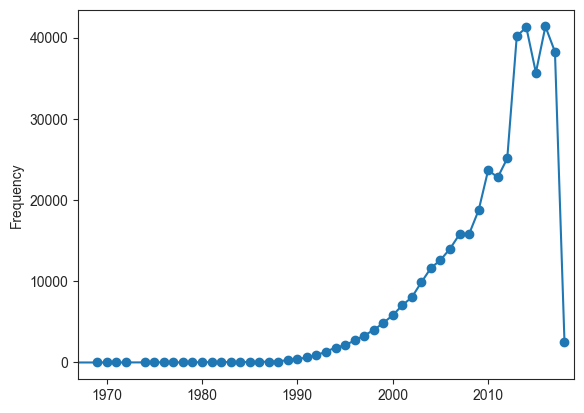

In [201]:
pub_df = merged_df.dropna(subset='publicationYear')
pub_df_x = pub_df.publicationYear.value_counts().sort_index().index
pub_df_y = pub_df.publicationYear.value_counts().sort_index().values
plt.plot(pub_df_x, pub_df_y, marker='o', linestyle='-')
plt.xlim(1967,2019)
plt.ylabel('Frequency')
plt.show()

### pH

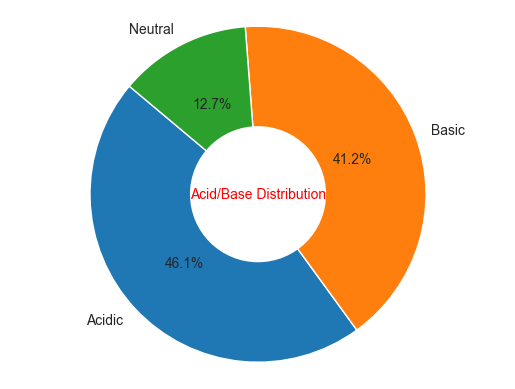

In [204]:
merged_df['Acid_or_base'] = merged_df['phValue'].apply(lambda x: 'Acidic' if x < 7 else 'Basic' if x > 7 else 'Neutral')
ph_df = merged_df.dropna(subset='phValue')
acid_base_counts = ph_df['Acid_or_base'].value_counts()
plt.pie(acid_base_counts, labels=acid_base_counts.index, autopct='%1.1f%%', startangle=140)
center_circle = plt.Circle((0, 0), 0.4, color='white', linewidth=1.25)
plt.gca().add_artist(center_circle)
plt.text(0, 0, 'Acid/Base Distribution', ha='center', va='center', fontsize=10, color = 'red')
plt.axis('equal')
plt.show()


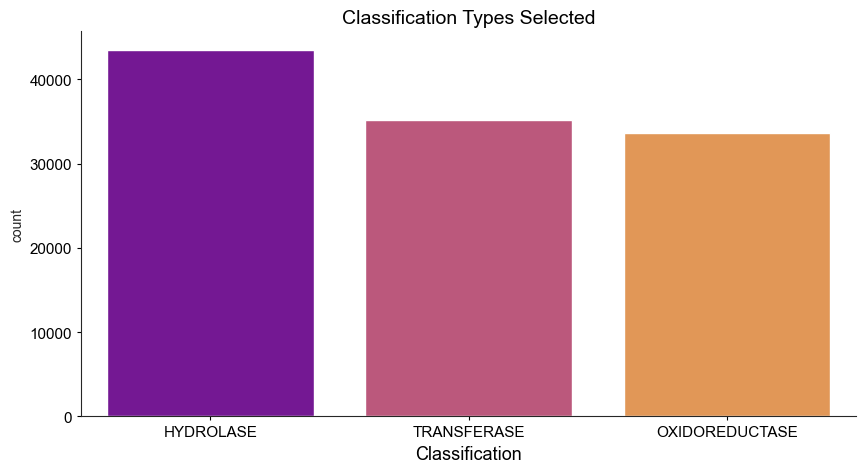

In [268]:
import warnings
warnings.filterwarnings("ignore")

clasific =merged_df.classification.value_counts(ascending=False)
df_class = pd.DataFrame(round(((clasific/merged_df.shape[0])*100),2).head(10)).reset_index()
df_class.columns = ['Classification', 'percent_value']

df_class.Classification.values.tolist()[1:4]
macrotype = ['Protein','Protein#RNA']
df_protein = merged_df[(merged_df['experimentalTechnique'] =='X-RAY DIFFRACTION') & 
                      (merged_df['macromoleculeType'].isin(macrotype))&
                     (merged_df['classification'].isin(df_class.Classification.values.tolist()[1:4]))]
df_protein.reset_index(drop=True,inplace=True)
columns = ['crystallizationMethod' ,'pdbxDetails', 'publicationYear','phValue','crystallizationTempK']
df_protein.drop(columns=columns,inplace=True)
f,ax= plt.subplots(figsize=(10,5))
sns.countplot(x='classification', data=df_protein, ax=ax, palette = 'plasma')
ax.set_title('Classification Types Selected', fontsize=14, color='black')
ax.tick_params(length=3, labelsize=11, colors='black')
ax.set_xlabel('Classification', fontsize=13, color='black')
sns.despine()
plt.show()

In [269]:
from scipy import stats
from scipy.stats import norm, skew, kurtosis

def stat_kde_plot(x,x1,x2):
    f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    sns.kdeplot(df_protein[x],ax = ax1,color ='blue',shade=True,
                label=("Skewness : %.2f"%(df_protein[x].skew()),
                       "Kurtosis: %.2f"%(df_protein[x].kurtosis())))
    sns.kdeplot(df_protein[x1], ax = ax2,color='r',shade=True,
                label=("Skewness : %.2f"%(df_protein[x1].skew()),
                       "Kurtosis: %.2f"%(df_protein[x1].kurtosis())))
    sns.kdeplot(df_protein[x2], ax = ax3,color='gray',shade=True,
                label=("Skewness : %.2f"%(df_protein[x2].skew()),
                       "Kurtosis: %.2f"%(df_protein[x2].kurtosis())))
    axes = [ax1,ax2,ax3]
    input = [x,x1,x2]
    for j in range(len(axes)):
        axes[j].set_xlabel(input[j],color='black',fontsize=12)
        axes[j].set_title(input[j] + ' Kdeplot',fontsize=14)
        axes[j].axvline(df_protein[input[j]].mean() , color ='g',linestyle = '--')
        axes[j].legend(loc ='upper right',fontsize=12,ncol=2)
    sns.despine()
    return plt.show()


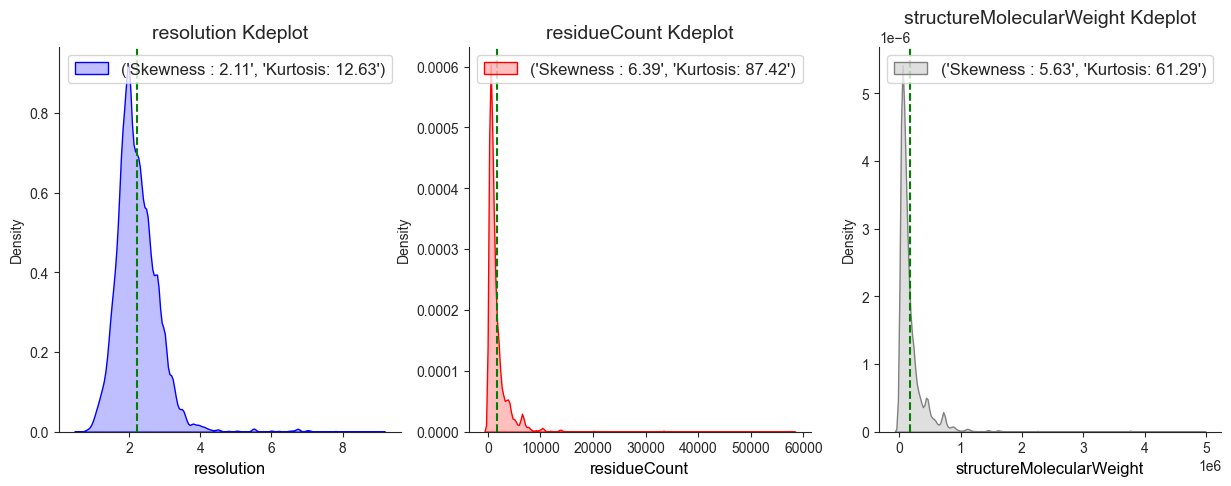

In [272]:
stat_kde_plot('resolution','residueCount','structureMolecularWeight')

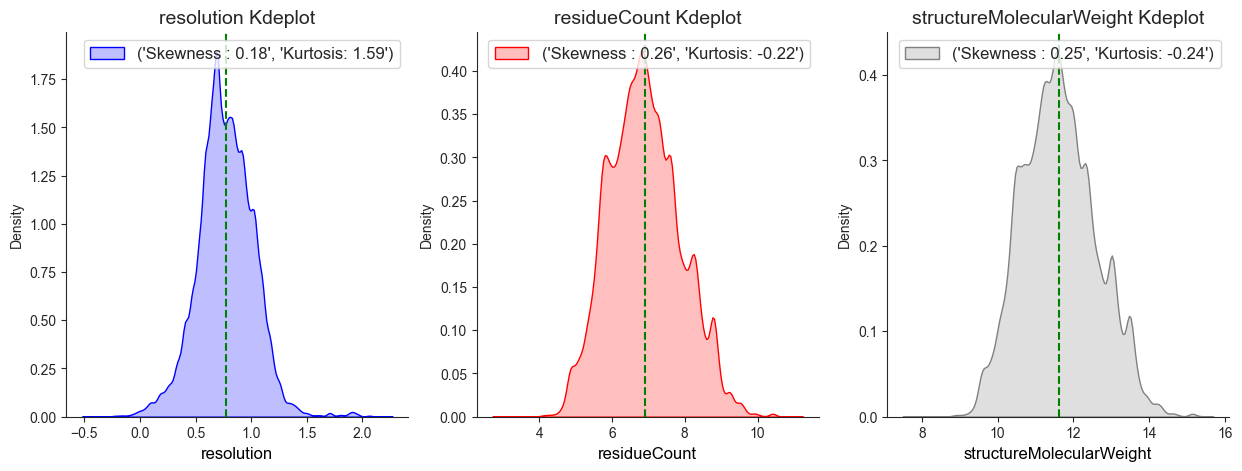

In [274]:
#Log values
columns_to_transform = ['resolution', 'residueCount', 'structureMolecularWeight']
for column in columns_to_transform:
    df_protein[column] = np.where(df_protein[column] > 0, np.log(df_protein[column]), 0)
stat_kde_plot('resolution','residueCount','structureMolecularWeight') 

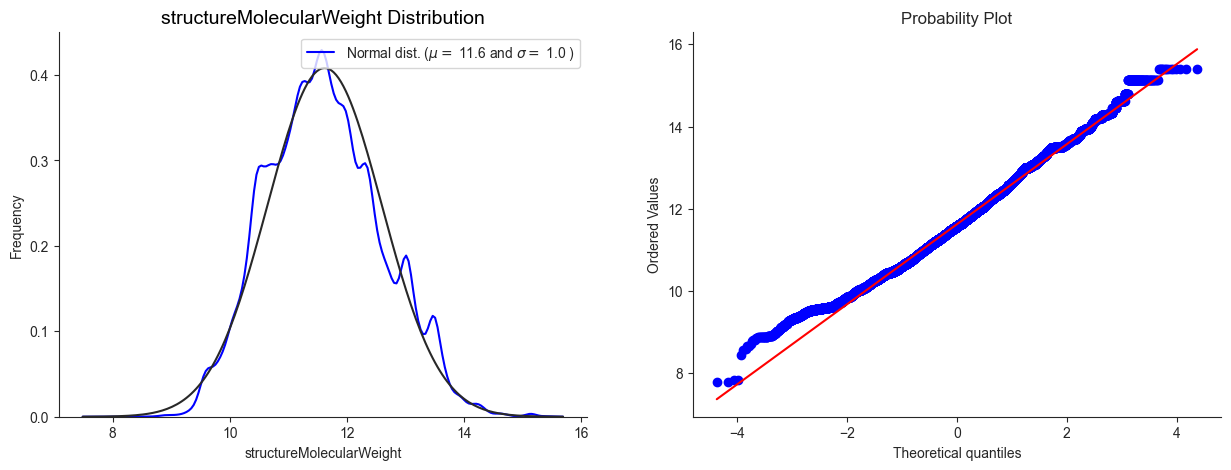

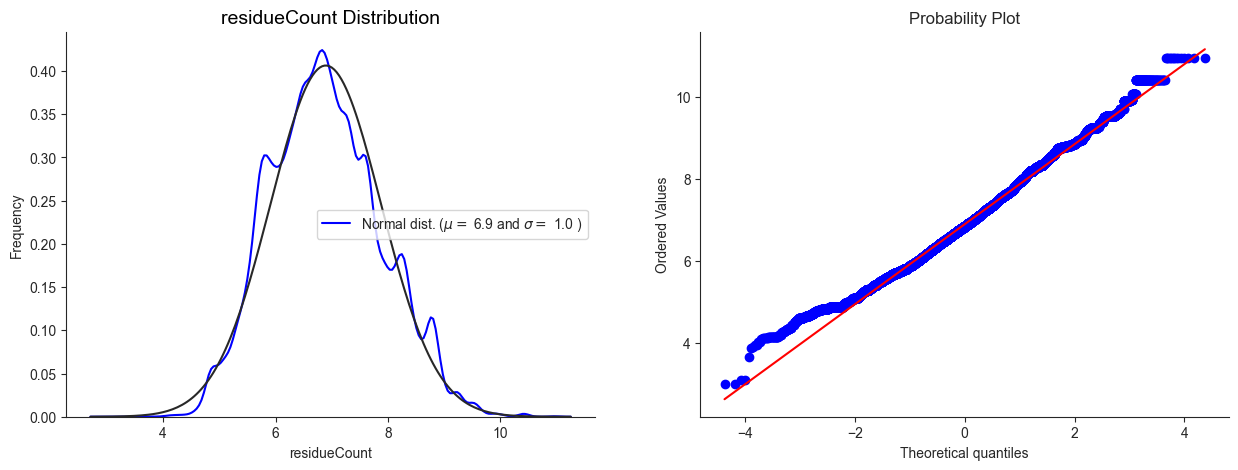

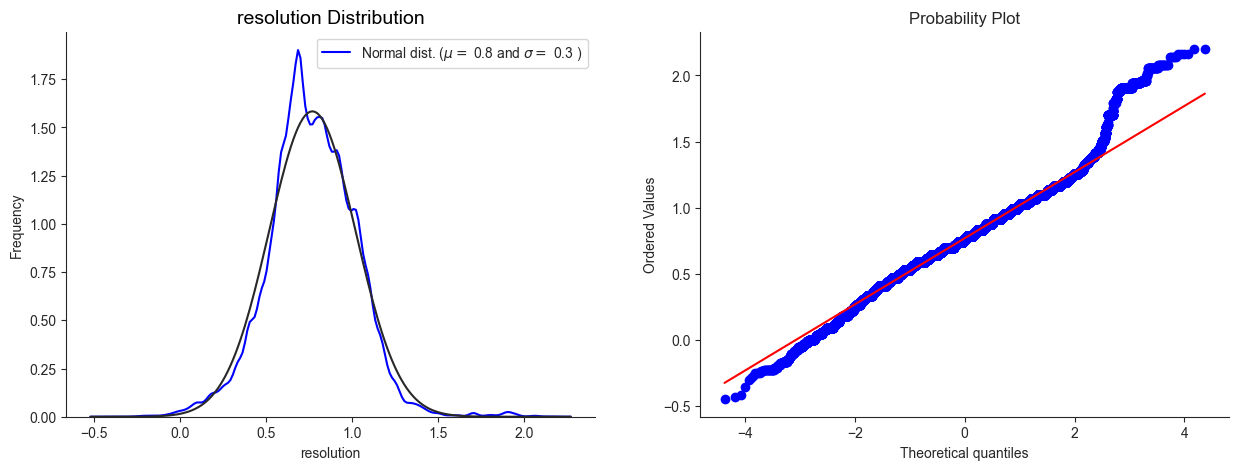

In [294]:
def stat_plot (input):
    (mu, sigma) = norm.fit(df_protein[input])
    f, (ax1, ax2)= plt.subplots(1,2,figsize=(15,5))
    # Apply the log transformation on the column
    sns.distplot(df_protein[input],ax = ax1,fit=norm,color ='blue',hist=False)
    ax1.legend(['Normal dist. ($\mu=$ {:.1f} and $\sigma=$ {:.1f} )'.format(mu, sigma)],loc='best')
    ax1.set_ylabel('Frequency')
    ax1.set_title(input +' Distribution',color='black',fontsize=14)
    #Get also the QQ-plot
    res = stats.probplot(df_protein[input], plot=ax2)
    sns.despine()
    return plt.show()
stat_plot('structureMolecularWeight')
stat_plot('residueCount')
stat_plot('resolution')

